In [1]:
import tqdm
import pandas as pd 
import numpy as np 
import os
from itertools import chain
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU') 
        print(gpus[0].name)
    except RuntimeError as e:
        print(e)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
img_labels_df = pd.read_csv('data/image_labels.csv')

img_labels_df

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,original_y_spacing
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [7]:
img_labels_df['split_diagnoses'] = img_labels_df.apply(lambda x: x['diagnosis'].split('|'), axis=1)
img_labels_df = img_labels_df[img_labels_df['split_diagnoses'].apply(lambda x: len(x) == 1)]
no_finding_df = img_labels_df[img_labels_df['diagnosis'] == 'No Finding']
no_finding_df.shape
no_findings_rows_to_drop = no_finding_df.sample(frac=0.85).index
img_labels_df = img_labels_df.drop(no_findings_rows_to_drop)

In [8]:
all_diagnoses = list(set(chain(*img_labels_df['diagnosis'].map(lambda x: x.split('|')).tolist())))
for diagnosis in all_diagnoses:
    img_labels_df[diagnosis] = img_labels_df['diagnosis'].map(lambda diagnoses: diagnosis in diagnoses)

diagnosis_counts = {diagnosis: img_labels_df[diagnosis].sum() for diagnosis in all_diagnoses}

print(f"Dataframe Shape: {img_labels_df.shape}")
img_labels_df.head(10)

Dataframe Shape: (40017, 27)


,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Mass,Cardiomegaly,Edema,Effusion,No Finding,Pleural_Thickening,Hernia,Pneumonia,Pneumothorax,Consolidation
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,False,True,False,False,False,False,False,False,False,False
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,True,False,False,False
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,...,False,False,False,False,False,False,True,False,False,False
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,True,False,False,False
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,...,False,False,False,False,False,False,True,False,False,False
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,True,False,False,False
10,00000003_007.png,Hernia,6,3,80,F,PA,2582,2905,0.143,...,False,False,False,False,False,False,True,False,False,False
11,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,...,False,False,False,False,False,False,True,False,False,False
19,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
23,00000008_000.png,Cardiomegaly,0,8,68,F,PA,2048,2500,0.171,...,False,True,False,False,False,False,False,False,False,False


In [9]:
img_labels_df['vectorized_diagnoses'] = img_labels_df.apply(lambda x: [x[all_diagnoses].values], 1).map(lambda x: [float(val) for val in x[0]])
img_labels_df["img_path"] = img_labels_df['img_name'].apply(lambda x: "./data/images/" + x)

In [10]:
split: list[pd.DataFrame] = train_test_split(img_labels_df, test_size=0.15, random_state=2003)
training_df, validation_df = split
print(f"Training Size: {len(training_df)}\nValidation Size: {len(validation_df)}")

Training Size: 34014
Validation Size: 6003


In [1]:
training_df.sample(10)

NameError: name 'training_df' is not defined

In [12]:
validation_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Edema,Effusion,No Finding,Pleural_Thickening,Hernia,Pneumonia,Pneumothorax,Consolidation,vectorized_diagnoses,img_path
83667,00020524_023.png,Infiltration,21,20524,48,F,PA,2580,2523,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00020524_023.png
10444,00002704_020.png,Atelectasis,20,2704,39,F,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00002704_020.png
97936,00025844_004.png,Atelectasis,4,25844,48,M,AP,3056,2544,0.139,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00025844_004.png
18587,00004928_002.png,Nodule,2,4928,27,M,AP,2500,2048,0.171,...,False,False,False,False,False,False,False,False,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00004928_002.png
96336,00025360_005.png,Effusion,5,25360,58,F,AP,3056,2544,0.139,...,False,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",./data/images/00025360_005.png
96694,00025480_003.png,Atelectasis,3,25480,71,M,AP,3056,2544,0.139,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00025480_003.png
54554,00013670_061.png,Edema,61,13670,55,M,AP,2500,2048,0.168,...,True,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./data/images/00013670_061.png
84842,00020904_002.png,Infiltration,12,20904,51,M,PA,2966,2859,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00020904_002.png
73642,00018104_006.png,Edema,4,18104,42,F,AP,2316,2436,0.139,...,True,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./data/images/00018104_006.png
102505,00027320_002.png,Atelectasis,1,27320,52,M,AP,3056,2544,0.139,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00027320_002.png


In [13]:
idg_parameterized = ImageDataGenerator(height_shift_range= 0.07,
                                  width_shift_range=0.12,
                                  rotation_range=5,
                                  zoom_range=0.17,
                                  shear_range = 0.12,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  samplewise_center=True, 
                                  samplewise_std_normalization=True, 
                                  fill_mode = 'reflect',
                                )
img_dimensions = (128, 128)

In [14]:
training_gen = idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = "img_path",
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'rgb',
                            batch_size = 32)

Found 34014 validated image filenames belonging to 15 classes.


In [15]:
validation_gen = idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                            directory=None,
                            x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                            class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                            color_mode = 'rgb',
                            batch_size = 256)

Found 6003 validated image filenames belonging to 15 classes.


In [16]:
t_X, t_Y = next(idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'rgb',
                            batch_size = 1024))

Found 34014 validated image filenames belonging to 15 classes.


In [17]:
v_X, v_Y = next(idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'rgb',
                            batch_size = 1024))

Found 6003 validated image filenames belonging to 15 classes.


In [18]:
print(len(t_X[0]))

128


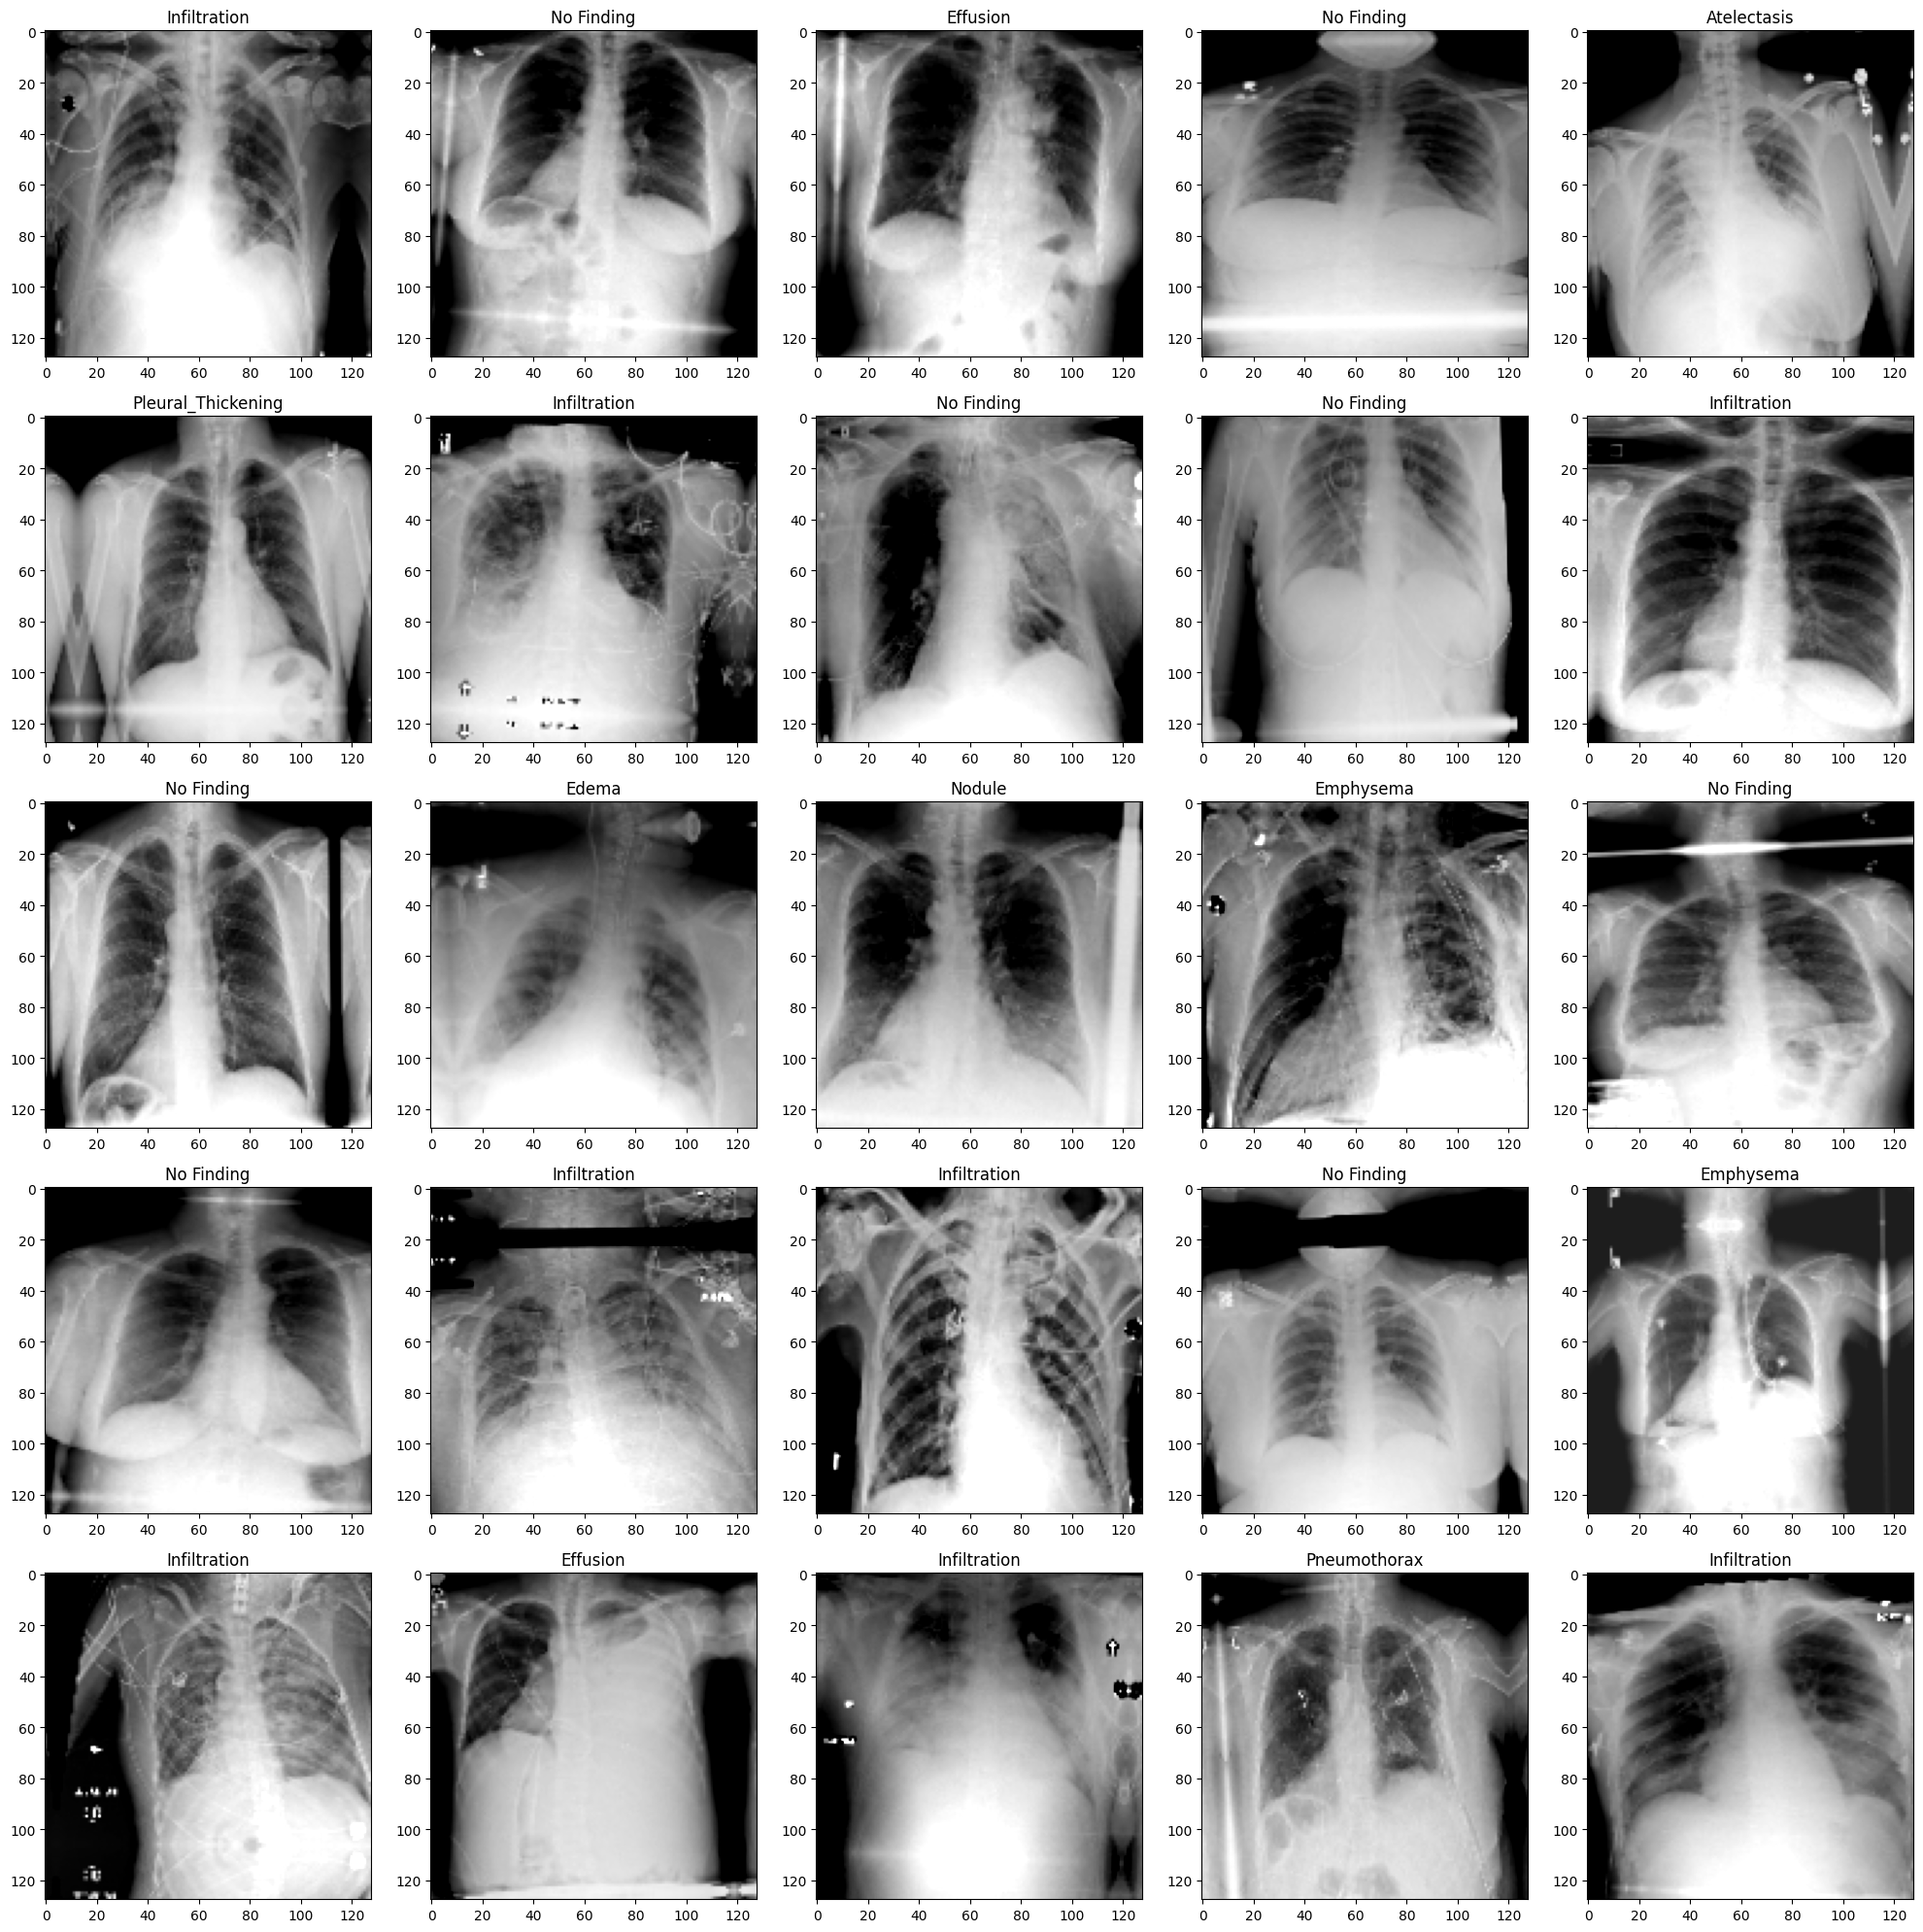

In [19]:
grid_size = 5

tr_x, tr_y = next(training_gen)

fig, matrix_axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))
for (img, labels, ax) in zip(tr_x, tr_y, matrix_axs.flatten()):
    ax.imshow(img[:, :, 0], cmap='gist_gray', vmin=-1.5, vmax=1.5)
    title = ', '.join([diagnosis for diagnosis, score in zip(all_diagnoses, labels) if score > 0.5])
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [20]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(all_diagnoses), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-best.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# Train the model
history = model.fit(
    training_gen,
    validation_data=validation_gen,
    epochs=1,
    callbacks=callbacks
)


  15/1063 [..............................] - ETA: 14:42 - loss: 3.5487 - accuracy: 0.1604

KeyboardInterrupt: 

In [43]:
test_loss, test_acc= model.evaluate(v_X, v_Y, verbose=2)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

32/32 - 3s - loss: 2.0927 - accuracy: 0.2920 - 3s/epoch - 92ms/step
Test accuracy: 0.2919921875
Test loss: 2.0927391052246094


In [44]:
# Assuming X_test is your test set
predictions = model.predict(v_X)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(v_Y, axis=1)

32/32 [==============================] - 3s 97ms/step


In [45]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=all_diagnoses))

# Generate and display confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

                    precision    recall  f1-score   support

          Effusion       0.26      0.29      0.27        92
      Pneumothorax       0.00      0.00      0.00        60
              Mass       0.00      0.00      0.00        61
        No Finding       0.30      0.50      0.37       203
       Atelectasis       0.26      0.09      0.13       103
            Nodule       0.00      0.00      0.00        87
             Edema       0.00      0.00      0.00        19
     Consolidation       0.00      0.00      0.00        29
Pleural_Thickening       0.00      0.00      0.00        35
         Pneumonia       0.00      0.00      0.00         9
      Infiltration       0.30      0.62      0.40       262
          Fibrosis       0.00      0.00      0.00        18
            Hernia       0.00      0.00      0.00         2
      Cardiomegaly       0.00      0.00      0.00        27
         Emphysema       0.00      0.00      0.00        17

          accuracy                    

d:\projects\chest_xray8_analytics\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projects\chest_xray8_analytics\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projects\chest_xray8_analytics\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu